# Age and gender across care units of adult patients
This notebook consists of two separate queries: the age distribution across care units, and the gender distribution across care units. For both queries, we filter on age >= 16.
## 1. Age across care units
We would like to know the age (in years, with age >= 16) distribution over all care units combined, as well as across the different care units. More specifically, we are interested in the median, lower quartile and upper quartile. It is better not to use the mean here, because, for privacy reasons, age > 89 is set to 300 in the database. The result can be visualized by means of a violin plot.
### SQL query description
To obtain age, we need to combine the Patients and the Icustays tables. Age can be computed by subtracting the time of admission to the ICU from a patient’s date of birth. Moreover, to get the age distribution across ICUs, we can use the different care units obtained from the Icustays table.
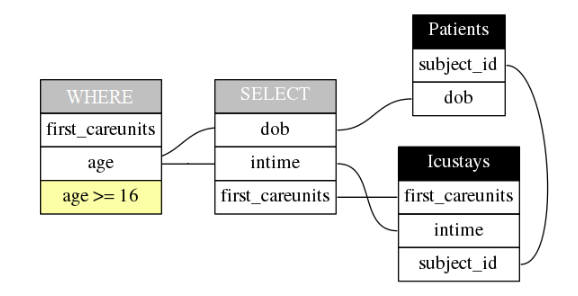
### Implementation of the above query

In [1]:
#imports:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys
import psycopg2
%matplotlib inline
# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'
# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [2]:
query ="""
SELECT i.first_careunit, round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i on p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""

In [3]:
query_output = pd.read_sql_query(query,con)

In [4]:
print('Age over all intensive care units combined: ')
print('Median age (in years): ', query_output.age.median())
print('Lower quartile age (in years)', query_output.age.quantile(0.25))
print('Upper quartile age (in years)', query_output.age.quantile(0.75))

Age over all intensive care units combined: 
Median age (in years):  65.769
Lower quartile age (in years) 52.8361
Upper quartile age (in years) 77.80005


In [6]:
print('Age per intensive care unit: ')
print('Median age (in years): ', query_output.groupby('first_careunit').age.median())
print('Lower quartile age (in years)', query_output.groupby('first_careunit').age.quantile(0.25))
print('Upper quartile age (in years)', query_output.groupby('first_careunit').age.quantile(0.75))

Age per intensive care unit: 
Median age (in years):  first_careunit
CCU      70.5697
CSRU     67.9286
MICU     64.9124
SICU     63.5819
TSICU    59.6125
Name: age, dtype: float64
Lower quartile age (in years) first_careunit
CCU      58.44555
CSRU     58.32150
MICU     51.65590
SICU     51.44315
TSICU    42.45665
Name: age, dtype: float64
Upper quartile age (in years) first_careunit
CCU      80.541375
CSRU     76.727250
MICU     78.170950
SICU     76.457500
TSICU    75.601550
Name: age, dtype: float64


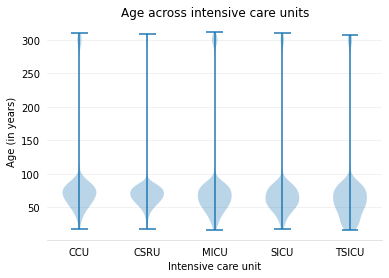

In [7]:
# Visualize with a violin plot:
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
boxplot_data = {}
for c in care_units:
   boxplot_data[c] = query_output.loc[query_output['first_careunit'] == c].age

fig, ax = plt.subplots()
plt.title('Age across intensive care units', fontsize='large', fontweight='roman')
plt.xlabel('Intensive care unit')
plt.ylabel('Age (in years)')
ax.violinplot(boxplot_data.values())
ax.set_xticks(np.arange(1, len(care_units) + 1))
ax.set_xticklabels(boxplot_data.keys())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.savefig('figures/age_violin.jpg', dpi=400)

## 2. Gender across care units
We would like to know the number of males / females in total and across the different ICUs, counting only patients of 16 years and older.
### SQL query description
We combine the Patients and Icustays tables based on each subject’s unique identifier. For each patient, we collect the ICU the patient was admitted to, gender, date of birth, and hospital admission time. The latter two are used to compute age and filter on adult patients only (age >= 16).
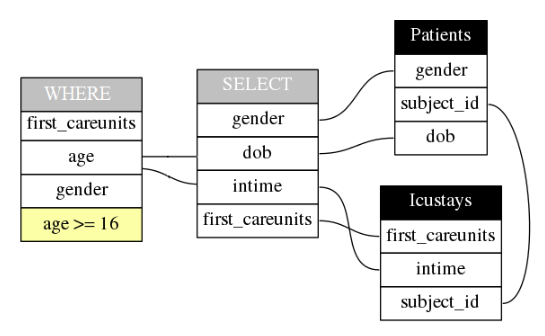
### Implementation of the above query

In [8]:
query ="""
SELECT p.subject_id, p.gender, i.first_careunit, 
round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age, i.hadm_id, i.intime,
DENSE_RANK() over(PARTITION BY i.hadm_id ORDER BY i.intime ASC) as icu_seq
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i on p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""

In [9]:
query_output = pd.read_sql_query(query,con)

In [10]:
print('Total number of males / females: ')
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count())

Total number of males / females: 
gender
F    21802
M    27983
Name: gender, dtype: int64


In [11]:
print('Number of males / females per critical care unit:')
print(query_output.loc[query_output.icu_seq==1].groupby(['first_careunit','gender']).gender.count())

Number of males / females per critical care unit:
first_careunit  gender
CCU             F          3055
                M          4203
CSRU            F          2963
                M          5677
MICU            F          9577
                M         10193
SICU            F          3859
                M          4251
TSICU           F          2348
                M          3659
Name: gender, dtype: int64


In [13]:
# Or we can compute the percantages:
print('Percentages of males / females: ')
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count() / 
      query_output.loc[query_output.icu_seq==1].gender.count() * 100)

Percentages of males / females: 
gender
F    43.792307
M    56.207693
Name: gender, dtype: float64


In [14]:
print('Percentages of males / females per critical care unit:')
print(query_output.loc[query_output.icu_seq==1].groupby(['first_careunit','gender']).gender.count() /
      query_output.loc[query_output.icu_seq==1].groupby('first_careunit').gender.count() * 100)

Percentages of males / females per critical care unit:
first_careunit  gender
CCU             F         42.091485
                M         57.908515
CSRU            F         34.293981
                M         65.706019
MICU            F         48.442084
                M         51.557916
SICU            F         47.583231
                M         52.416769
TSICU           F         39.087731
                M         60.912269
Name: gender, dtype: float64


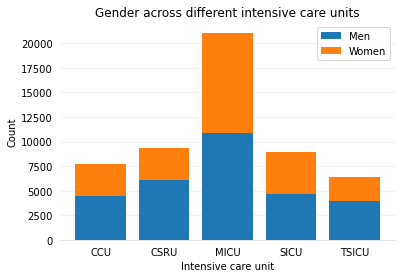

In [15]:
# Visualize:
counts_men = []
counts_women = []
for c in care_units:
    men = query_output.loc[(query_output['first_careunit'] == c) & (query_output['gender'] == 'M')].shape[0]
    counts_men.append(men)
    women = query_output.loc[(query_output['first_careunit'] == c) & (query_output['gender'] == 'F')].shape[0]
    counts_women.append(women)
fig, ax = plt.subplots()
ax.bar(care_units, counts_men, label='Men')
ax.bar(care_units, counts_women, label='Women', bottom=counts_men)
plt.xlabel('Intensive care unit')
plt.ylabel('Count')
plt.title('Gender across different intensive care units')
plt.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.savefig('figures/gender_stacked_barchart.jpg', dpi=400)